In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sn
import glob
import os
import sys

import plotly.express as px
import seaborn as sns

# Definir carpetas y archivos a utilizar
---
Arbol de archivos
```bash
 root
 ├───Codigos Python
 ├───Datos
 |   ├───Datos_CEN: Informacion de generacion historica en archivos .tsv para cada mes. Fuente:
 |   ├───Capacidad Instalada.xlsx: Informacion de capacidad instalada para cada mes. Fuente:
 |   └───Coordenadas.xlsx: Informacion de ubicacion geografica de centrales. Fuente:
 ├───Figuras: Carpeta que contiene las figuras de los codigos
 └───Output: Carpeta que contiene salidas de los programas, ejemplo: generación por cluster
 ```

In [2]:
root_dir = os.path.dirname(os.getcwd())

# Directorios principales
ProcesamientoDatos_dir = os.path.join(root_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(root_dir, 'b. Estudio Correlacion y Sistema')
Simulacion_dir = os.path.join(root_dir, 'c. Simulacion sistema')

# Datos de entrada
Datos_dir = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada')
GenData_dir = os.path.join(Datos_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')

# Directorios de procesamiento de datos
Output_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

#Crear las carpetas que no existan
if not os.path.exists(Output_dir): os.makedirs(Output_dir)

# Directorios de coordenadas de centrales generado por el script 1.-GenerarCoordenadasCentrales.ipynb
coord_dir = os.path.join(Output_dir, 'Coordenadas_CEN.xlsx')
df_coord = pd.read_excel(coord_dir)

In [3]:
# fix parameters
LAST_DAY = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
LEAP_YEARS = [2020,2024,2028,2032,2036,2040,2044,2048,2052,2056,2060]  # Años bisiestos
MONTHS = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']  # Vector con los meses del año
MONTHS_NUMBERS = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08','septiembre':'09','octubre':'10','noviembre':'11','diciembre':'12'}  # Diccionario que relaciona el nombre del mes con su número
NUMBER_MONTHS = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}  # Diccionario que relaciona el número del mes con su nombre

In [4]:
# Creación de función para importar generación de cada central, en resolución horaria

def GenerarDataset_Bruto():

    # Vectores que contienen los archivos en datosCEN en formato tsv
    files = [file for file in os.listdir(datosCEN_dir) if file.endswith('.tsv')]
    n_files = len(files)  # Número de archivos en el directorio

    # Enlace 'raw' a GitHub que contiene los archivos
    #link = 'https://raw.githubusercontent.com/BryanLevy/Memoria/main/Datos%202020-2022/'

    print("-"*83+f"\n"+" Leyendo Datos de generación...")
    idx = 1  # Se define un índice para el print
    df = pd.DataFrame()  # Se crea el dataframe
    for f in files:  # Acciones a realizar para cada archivo en el vector
        file = os.path.join(datosCEN_dir,f)  # Se concatena el nombre del archivo al enlace, obteniendo la ubicación de cada archivo
        aux = pd.read_csv(file, sep='\t')  # Se lee en una varbiable auxiliar la información de cada archivo
        df = pd.concat([df,aux])  # Se concatena la información leída de cada archivo al dataframe

        #print
        info1,info2 = "Leyendo:"," Progreso:"
        progress = f"{idx}/{n_files}"
        sys.stdout.write(f"\r{info2:.<20}{progress:.>20} | {info1:.<20}{f:.>20}")
        idx += 1
    
    print("\n"+" Generación de dataset bruto:",end="")

    df =df.reset_index()  # Se reinicia el índice del dataframe
    
    df = df.drop(df[df['hora_opreal'] > 24].index) # Se borran datos que se encuentran operando en horas imposibles
    df['hora_opreal'] = df['hora_opreal'] - 1  # Se ajusta el rango de operación diario entre las 00:00 hasta las 23:00 hrs 

    df['time'] = df['fecha_opreal'] + ' ' + df['hora_opreal'].astype('str')+':00:00'  # Se define un parámetro que incluye la fecha y la hora de operación
    df['time'] = df['time'].str.replace('-','/')  # Se reemplazan los slash de la fecha por guiones
    df['time'] = pd.to_datetime(df['time'])  # Se deja en formato de tiempo compatible con pandas la fecha y hora de cada dato 

    print("...............................Listo")
    print("-"*83)
    
    return df  # Se termina de definir la función, retornando df

def PreprocesarPerfil(df_Perfil):
    df_Perfil_out = df_Perfil.copy(deep=True)
    df_Perfil_out['Date'] = pd.to_datetime(df_Perfil_out['time']) #Deglosa la fecha que viene en los perfiles a datos trabajables
    df_Perfil_out.insert(0, 'Year', df_Perfil_out['Date'].dt.year)
    df_Perfil_out.insert(1, 'Month', df_Perfil_out['Date'].dt.month)
    df_Perfil_out.insert(2, 'Day', df_Perfil_out['Date'].dt.day)
    df_Perfil_out.insert(3, 'Hour', df_Perfil_out['Date'].dt.hour)
    df_Perfil_out = df_Perfil_out.drop(['Date','time'], axis=1)
    # Eliminar el dia 29 de febrero de todos los años si es que existe
    #df_Perfil_out = df_Perfil_out.drop(df_Perfil_out[(df_Perfil_out['Month'] == 2) & (df_Perfil_out['Day'] == 29)].index).reset_index(drop=True)
    return df_Perfil_out
    

def extraerhidraulicas_pasada(df_input):
    df_out = df_input[df_input['central_tipo'] == 'Hidráulica']  # Se crea un dataframe con las centrales hidráulicas
    for central in df_out.central_nombre.unique():
        df_central = df_out[df_out['central_nombre'] == central]
        # Revisar si la generacion ernc es igual a 0
        if df_central['generacion_real_ernc_mwh'].sum() == 0:
            df_out = df_out.drop(df_central.index)
    return df_out

In [5]:
df_raw = GenerarDataset_Bruto()

-----------------------------------------------------------------------------------
 Leyendo Datos de generación...
 Progreso:.........................54/54 | Leyendo:......................2024-6.tsv
 Generación de dataset bruto:...............................Listo
-----------------------------------------------------------------------------------


In [6]:
df_raw[df_raw['generacion_real_ernc_mwh'] > 0]['central_tipo_nemotecnico'].unique()

array(['hidraulica', 'termica', 'eolica', 'geotermica', 'solar'],
      dtype=object)

In [7]:
def GenerateDatasets(df_raw):
    df_GenSist = df_raw.copy(deep=True)

    # Eliminar todos los que tengan la fecha 02-29 en un año bisiesto
    for year in LEAP_YEARS:
        df_GenSist = df_GenSist.drop(df_GenSist[(df_GenSist['fecha_opreal'] == f'{year}-02-29')].index)

    solar = df_GenSist[df_GenSist['central_tipo']=='Solar'] #Datos de las centrales solares.
    eolica = df_GenSist[df_GenSist['central_tipo']=='Eólica'] # Datos de las centrales eólicas.
    hidraulica = df_GenSist[df_GenSist['central_tipo']=='Hidráulica'] # Datos de las centrales hidráulicas.

    eol = eolica.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.
    sol = solar.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.
    hid = hidraulica.pivot_table(values='generacion_real_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.
    dem = df_GenSist.pivot_table(values='generacion_real_mwh', columns='central_nombre',index='time')
    ren = df_GenSist.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre',index='time')

    # cambiar el nombre de central_nombre a None (es el string que aparece sobre el indice luego de hacer el pivot_table)
    eol.columns.name = None
    sol.columns.name = None
    hid.columns.name = None
    dem.columns.name = None
    ren.columns.name = None

    # Sumar las potencias de cada dataframe para conseguir las de sistema
    eol_sum = eol.sum(axis=1).rename('Eolica')
    sol_sum = sol.sum(axis=1).rename('Solar')
    hid_sum = hid.sum(axis=1).rename('Hidro')
    dem_sum = dem.sum(axis=1).rename('Demanda')
    ren_sum = ren.sum(axis=1).rename('ERNC')

    # Concatenar los dataframes en uno solo
    df_PotenciaSistema_raw = pd.concat([eol_sum,sol_sum,hid_sum,dem_sum,ren_sum], axis=1)
    df_PotenciaSistema_raw = PreprocesarPerfil(df_PotenciaSistema_raw.reset_index())

    # Datos con resolucion diaria en formato array
    df_sol = PreprocesarPerfil(sol.reset_index())
    df_eol = PreprocesarPerfil(eol.reset_index())
    df_ren = PreprocesarPerfil(ren.reset_index())
    df_dem = PreprocesarPerfil(dem.reset_index())

    # Se separan las centrales hidroeléctricas según tipo de central

    filtro_pasada = [col for col in hid if col.startswith('HP')]  # Se extraen las columnas que poseen centrales hidroeléctricas de pasada
    filtro_embalse = [col for col in hid if col.startswith('HE')]  # Se extraen las columnas que poseen centrales hidroeléctricas de embalse
    filtro_pmgd_pasada = [col for col in hid if col.startswith('PMGD HP')]  # Se extraen las columnas que poseen centrales hidroeléctricas de pasada con potencia <20 MW

    pasada = hid[filtro_pasada]  # Datos de centrales hidroeléctricas de pasada
    embalse = hid[filtro_embalse]  # Datos de centrales hidroeléctricas de embalse
    pmgd_pasada = hid[filtro_pmgd_pasada]  # Datos de centrales hidroeléctricas de pasada con potencia <20 MW
    hidro = hid[filtro_pasada + filtro_pmgd_pasada]
    df_hid = PreprocesarPerfil(hidro.reset_index())

    return df_PotenciaSistema_raw, df_sol, df_eol, df_hid, df_dem, df_ren

def InterpolarHora(df_input:pd.DataFrame, Year:int ,Month:int, Day:int, Hour:int) -> pd.DataFrame:
    """
    Dado un dataframe con datos horarios, se interpola la hora dada en el año, mes y día correspondiente.
    Para hacer esto se promedia la hora anterior y la hora siguiente a la hora a interpolar.

    En caso de que la hora a interpolar no exista, se inserta en el dataframe y se interpola.
    En caso de que la hora a interpolar ya exista, se interpola y se reemplaza la hora con el promedio de la hora anterior y la hora siguiente.
    """


    df_out = df_input.copy(deep=True)

    # Revisar si la hora a insertar ya existe
    if len(df_out[(df_out['Year'] == Year) & (df_out['Month'] == Month) & (df_out['Day'] == Day) & (df_out['Hour'] == Hour)]) > 0:
        Existe = True
    else:
        Existe = False

    # Buscar el indice en que deberia estar la hora a insertar
    if Hour == 0: # Buscar el indice siguiente
        idx = df_out[(df_out['Year'] == Year) & (df_out['Month'] == Month) & (df_out['Day'] == Day) & (df_out['Hour'] == Hour+1)].index[0]
    else:
        idx = df_out[(df_out['Year'] == Year) & (df_out['Month'] == Month) & (df_out['Day'] == Day) & (df_out['Hour'] == Hour-1)].index[0]
        idx = idx + 1

    # Dividir el dataframe en dos
    if Existe:
        df1 = df_out.iloc[:idx-1]
    else:
        df1 = df_out.iloc[:idx]
    df2 = df_out.iloc[idx:]

    df1_tail = df1.iloc[-1:].copy(deep=True)
    df1_tail['Year'] = Year
    df1_tail['Month'] = Month
    df1_tail['Day'] = Day
    df1_tail['Hour'] = Hour
    df1_tail = df1_tail.set_index(["Year","Month","Day","Hour"])

    df2_head = df2.iloc[:1].copy(deep=True)
    df2_head['Year'] = Year
    df2_head['Month'] = Month
    df2_head['Day'] = Day
    df2_head['Hour'] = Hour
    df2_head = df2_head.set_index(["Year","Month","Day","Hour"])

    df_insert = (df1_tail+df2_head)/2
    df_insert = df_insert.reset_index()
    df_out = pd.concat([df1,df_insert,df2]).reset_index(drop=True)
    return df_out

### Asegurar que todos los dataframes tengan 8760 horas y remover centrales conflictivas
---
NOTA: en algunos años meses la informacion de CEN tiene datos faltantes o sobrantes, se eliminan de acuerdo a criterio humano

In [8]:
df_PotenciaSistema_raw, df_sol, df_eol, df_hid, df_dem, df_ren = GenerateDatasets(df_raw)

df_sol = InterpolarHora(df_sol,2020,9,6,0)
df_eol = InterpolarHora(df_eol,2020,9,6,0)
df_hid = InterpolarHora(df_hid,2020,9,6,0)
df_dem = InterpolarHora(df_dem,2020,9,6,0)
df_ren = InterpolarHora(df_ren,2020,9,6,0)
df_PotenciaSistema_raw = InterpolarHora(df_PotenciaSistema_raw,2020,9,6,0)

df_sol = InterpolarHora(df_sol,2021,9,5,0)
df_eol = InterpolarHora(df_eol,2021,9,5,0)
df_hid = InterpolarHora(df_hid,2021,9,5,0)
df_dem = InterpolarHora(df_dem,2021,9,5,0)
df_ren = InterpolarHora(df_ren,2021,9,5,0)
df_PotenciaSistema_raw = InterpolarHora(df_PotenciaSistema_raw,2021,9,5,0)

# 2022	9	11 0 The generation is extremely low
df_sol = InterpolarHora(df_sol,2022,9,11,0)
df_eol = InterpolarHora(df_eol,2022,9,11,0)
df_hid = InterpolarHora(df_hid,2022,9,11,0)
df_dem = InterpolarHora(df_dem,2022,9,11,0)
df_ren = InterpolarHora(df_ren,2022,9,11,0)
df_PotenciaSistema_raw = InterpolarHora(df_PotenciaSistema_raw,2022,9,11,0)

df_sol = InterpolarHora(df_sol,2023,9,3,0)
df_eol = InterpolarHora(df_eol,2023,9,3,0)
df_hid = InterpolarHora(df_hid,2023,9,3,0)
df_dem = InterpolarHora(df_dem,2023,9,3,0)
df_ren = InterpolarHora(df_ren,2023,9,3,0)
df_PotenciaSistema_raw = InterpolarHora(df_PotenciaSistema_raw,2023,9,3,0)

In [9]:
# Revisar si estan todas las horas necesarias
def Check_Hours(df_input, name):
    for Year in df_input['Year'].unique():
        df_Year = df_input[df_input['Year'] == Year]
        for Month in df_Year['Month'].unique():
            df_Month = df_Year[df_Year['Month'] == Month]
            for Day in df_Month['Day'].unique():
                df_Day = df_Month[df_Month['Day'] == Day]
                if len(df_Day) != 24:
                    print("-"*83)
                    print(f"Year: {Year}, Month: {Month}, Day: {Day}")
                    print(f"Missing hours in {name}")
                    display(df_Day)

Check_Hours(df_sol,'Solar')
Check_Hours(df_eol,'Eolica')
Check_Hours(df_hid,'Hidro')
Check_Hours(df_dem,'Demanda')
Check_Hours(df_ren,'ERNC')
Check_Hours(df_PotenciaSistema_raw,'Potencia Sistema')

# Quitar centrales conflictivas
---

In [10]:
# Eliminar central CSP CERRO DOMINADOR
df_sol = df_sol.drop(['CSP CERRO DOMINADOR'], axis=1)
df_dem = df_dem.drop(['CSP CERRO DOMINADOR'], axis=1)
df_ren = df_ren.drop(['CSP CERRO DOMINADOR'], axis=1)

### Quitar las centrales [en revision] o [No mostrar]

In [11]:
def RemoverCentrales_EnRevision(df_input: pd.DataFrame) -> pd.DataFrame:
    """
    Funcion que elimina toda central que tenga un nombre con el formato "Nombre Central [En Revision]" o "Nombre Central [No mostrar]"

    Args:
        df_input (DataFrame): DataFrame con los datos de generacion de cada central

    Returns:
        df_out (DataFrame): DataFrame con los datos de generacion de cada central sin las centrales en revision
    """
    df_out = df_input.copy(deep=True)
    centrales = df_out.columns
    for central in centrales:
        if "[" in central:
            df_out = df_out.drop(central, axis=1)
    return df_out

def RemoverCentrales_SinData(df_input: pd.DataFrame) -> pd.DataFrame:
    """
    Funcion que elimina toda central que no tenga datos de generacion, se define como no tener datos de generacion que todos sus valores sean NaN o bien que la suma de generacion sea 0

    Args:
        df_input (DataFrame): DataFrame con los datos de generacion de cada central

    Returns:
        df_out (DataFrame): DataFrame con los datos de generacion de cada central sin las centrales sin datos
    """
    df_out = df_input.copy(deep=True)
    centrales = df_out.columns
    for central in centrales:
        if df_out[central].isna().sum() == df_out.shape[0] or df_out[central].sum() == 0:
            df_out = df_out.drop(central, axis=1)
    return df_out

def RemoverCentrales_SinCoordenadas(df_tech_input: pd.DataFrame,df_coord: pd.DataFrame) -> pd.DataFrame:
    """
    Funcion que elimina todas las centrales de df_tech_input que no tengan coordenadas en df_coord

    Args:
        df_tech_input (DataFrame): DataFrame con los datos de generacion de cada central
        df_coord (DataFrame): DataFrame con las coordenadas de cada central

    Returns:
        df_out (DataFrame): DataFrame con los datos de generacion de cada central sin las centrales sin coordenadas
    """
    df_tech = df_tech_input.copy(deep=True)
    centrales = df_tech.columns[4:]
    for central in centrales:
        if central not in df_coord['Nombre'].unique():
            df_tech = df_tech.drop(central, axis=1)
    return df_tech

def CrearDataframe_Info(df_tech_input: pd.DataFrame,df_coord: pd.DataFrame) -> pd.DataFrame:
    """
    Funcion que crea un dataframe con la informacion de cada central, incluyendo su ubicacion geografica

    Args:
        df_tech_input (DataFrame): DataFrame con los datos de generacion de cada central
        df_coord (DataFrame): DataFrame con las coordenadas de cada central

    Returns:
        df_out (DataFrame): DataFrame con la informacion de cada central
    """
    df_tech = df_tech_input.copy(deep=True)
    centrales = df_tech.columns[4:]
    dfs = []
    for central in centrales:
        df = df_coord[df_coord['Nombre'] == central]
        dfs.append(df)
    df_tech_data = pd.concat(dfs, ignore_index=True)
    df_tech_data.sort_values(by=['ID'], inplace=True)
    df_tech_data.drop(['Este','Norte','Zona'], axis=1, inplace=True)
    return df_tech_data

def CrearDataframes(dfs_tech: list,df_coord: pd.DataFrame)-> pd.DataFrame:
    """
    Funcion que dada una lista de dataframes con los datos de generacion de cada tecnologia, crea dos listas de dataframes, una con los datos de generacion cada central y otra con la informacion de cada central
    un dataframe para cada tecnologia

    Args:
        dfs_tech (list): Lista de DataFrames con los datos de generacion de cada tecnologia
        df_coord (DataFrame): DataFrame con las coordenadas de cada central

    Returns:
        df_out (DataFrame): DataFrame con la informacion de cada central
    """
    dfs_tech_data = []
    dfs_tech_gen = []

    for df in dfs_tech:
        df_gen = df.copy(deep=True)
        print(f"Procesando {df.columns[0]}")
        print(f"Numero Centrales: {df.shape[1]-4}")
        df_gen = RemoverCentrales_EnRevision(df_gen)
        print(f"Numero Centrales sin En Revision: {df_gen.shape[1]-4}")
        df_gen = RemoverCentrales_SinData(df_gen)
        print(f"Numero Centrales sin datos: {df_gen.shape[1]-4}")
        df_gen = RemoverCentrales_SinCoordenadas(df_gen,df_coord)
        print(f"Numero Centrales sin coordenadas: {df_gen.shape[1]-4}")

        df_data = CrearDataframe_Info(df_gen,df_coord)

        dfs_tech_data.append(df_data)
        dfs_tech_gen.append(df_gen)
    return dfs_tech_data,dfs_tech_gen

In [12]:
dfs_tech = [df_sol,df_eol,df_hid, df_dem, df_ren]
dfs_tech_data,dfs_tech_gen = CrearDataframes(dfs_tech,df_coord)

df_sol_data = dfs_tech_gen[0]
df_eol_data = dfs_tech_gen[1]
df_hid_data = dfs_tech_gen[2]
df_dem_data = dfs_tech_gen[3]
df_ren_data = dfs_tech_gen[4]

df_sol_info = dfs_tech_data[0]
df_eol_info = dfs_tech_data[1]
df_hid_info = dfs_tech_data[2]
df_dem_info = dfs_tech_data[3]
df_ren_info = dfs_tech_data[4]

Procesando Year
Numero Centrales: 761
Numero Centrales sin En Revision: 602
Numero Centrales sin datos: 596
Numero Centrales sin coordenadas: 466
Procesando Year
Numero Centrales: 81
Numero Centrales sin En Revision: 60
Numero Centrales sin datos: 60
Numero Centrales sin coordenadas: 54
Procesando Year
Numero Centrales: 208
Numero Centrales sin En Revision: 191
Numero Centrales sin datos: 181
Numero Centrales sin coordenadas: 151
Procesando Year
Numero Centrales: 1348
Numero Centrales sin En Revision: 1115
Numero Centrales sin datos: 1080
Numero Centrales sin coordenadas: 877
Procesando Year
Numero Centrales: 1348
Numero Centrales sin En Revision: 1115
Numero Centrales sin datos: 852
Numero Centrales sin coordenadas: 679


In [13]:
df_eol_data

,Year,Month,Day,Hour,PE ALENA,PE AURORA,PE CABO LEONES,PE CABO LEONES II,PE CABO LEONES III,PE CALAMA,...,PE TOTORAL,PE UCUQUER II,PE VALLE DE LOS VIENTOS,PMGD PE EL ARREBOL,PMGD PE EL NOGAL,PMGD PE HUAJACHE,PMGD PE LAS PEÑAS,PMGD PE LEBU III,PMGD PE RAKI,PMGD PE UCUQUER
0,2020,1,1,0,NaN,113.30,4.70,NaN,NaN,NaN,...,0.0,0.00,6.6493,NaN,6.428544,5.750661,8.191932,0.895025,7.598362,0.000000
1,2020,1,1,1,NaN,103.70,0.80,NaN,NaN,NaN,...,0.0,0.00,0.0502,NaN,5.556577,4.494656,7.418644,0.478126,5.419370,0.000000
2,2020,1,1,2,NaN,68.80,0.00,NaN,NaN,NaN,...,0.0,0.04,0.8958,NaN,3.007792,3.469866,6.194368,0.454619,4.149369,0.154903
3,2020,1,1,3,NaN,99.60,0.00,NaN,NaN,NaN,...,0.0,0.09,0.6307,NaN,2.299366,2.372455,6.130867,0.299609,3.288258,0.274007
4,2020,1,1,4,NaN,75.10,0.00,NaN,NaN,NaN,...,0.0,0.07,0.4157,NaN,2.615824,2.234700,7.579557,0.335788,2.949745,0.262205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39379,2024,6,30,19,19.48,11.35,113.02,95.47,136.91,41.4,...,19.8,4.70,22.4800,0.068424,0.000000,0.000000,0.000000,0.000000,0.000000,3.862371
39380,2024,6,30,20,12.61,6.32,75.41,38.84,92.05,4.5,...,13.6,5.34,1.4100,0.226850,0.000000,0.000000,0.000000,0.000000,0.000000,4.337461
39381,2024,6,30,21,16.69,0.04,35.37,13.51,48.67,1.2,...,4.6,4.74,0.0000,0.310338,0.000000,0.000000,0.000000,0.000000,0.000000,4.391308
39382,2024,6,30,22,12.71,0.15,26.20,12.75,45.05,2.8,...,7.3,4.13,2.9400,0.053696,0.000000,0.000000,0.000000,0.000000,0.000000,4.507329


# Exportar Archivos
---

In [14]:
df_sol_data.to_parquet(os.path.join(Output_dir,'df_sol_data.parquet'))
df_eol_data.to_parquet(os.path.join(Output_dir,'df_eol_data.parquet'))
df_hid_data.to_parquet(os.path.join(Output_dir,'df_hid_data.parquet'))
df_dem_data.to_parquet(os.path.join(Output_dir,'df_dem_data.parquet'))
df_ren_data.to_parquet(os.path.join(Output_dir,'df_ren_data.parquet'))

df_PotenciaSistema_raw.to_parquet(os.path.join(Output_dir,'df_PotenciaSistema.parquet'))

with pd.ExcelWriter(os.path.join(Output_dir,'df_GenInfo.xlsx')) as writer:
    df_sol_info.to_excel(writer, sheet_name='Solar', index=False)
    df_eol_info.to_excel(writer, sheet_name='Eolica', index=False)
    df_hid_info.to_excel(writer, sheet_name='Hidro', index=False)
    df_dem_info.to_excel(writer, sheet_name='Demanda', index=False)
    df_ren_info.to_excel(writer, sheet_name='ERNC', index=False)

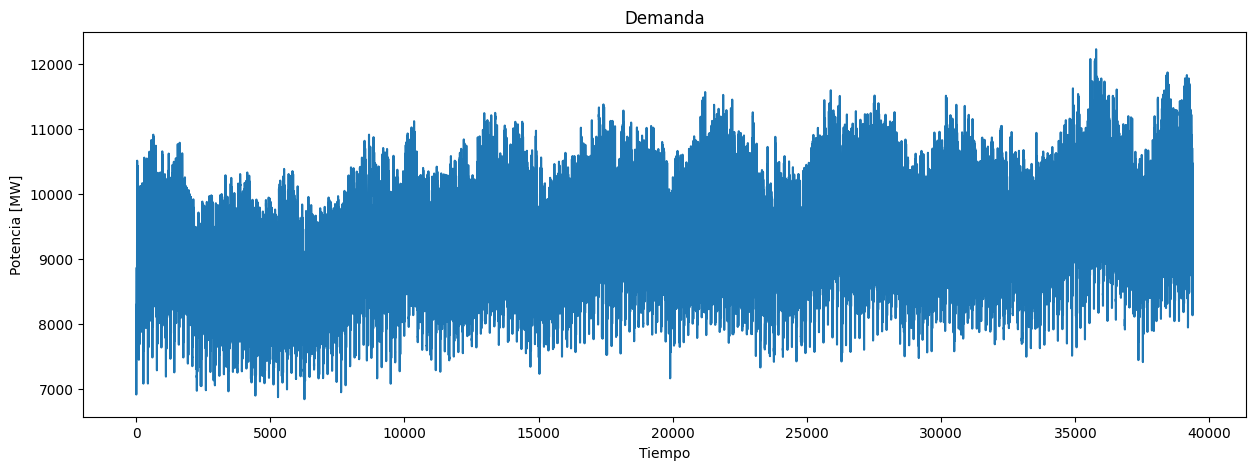

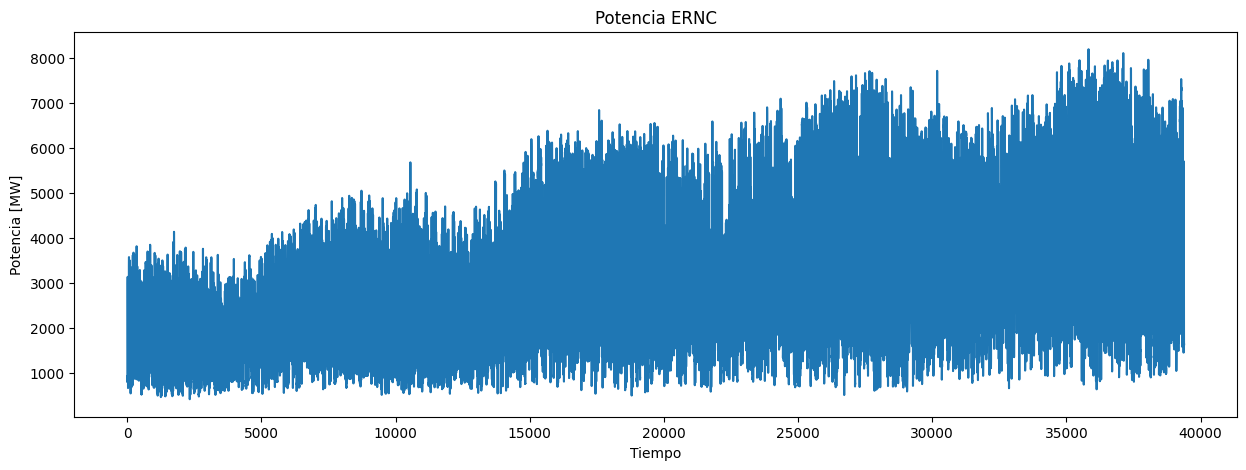

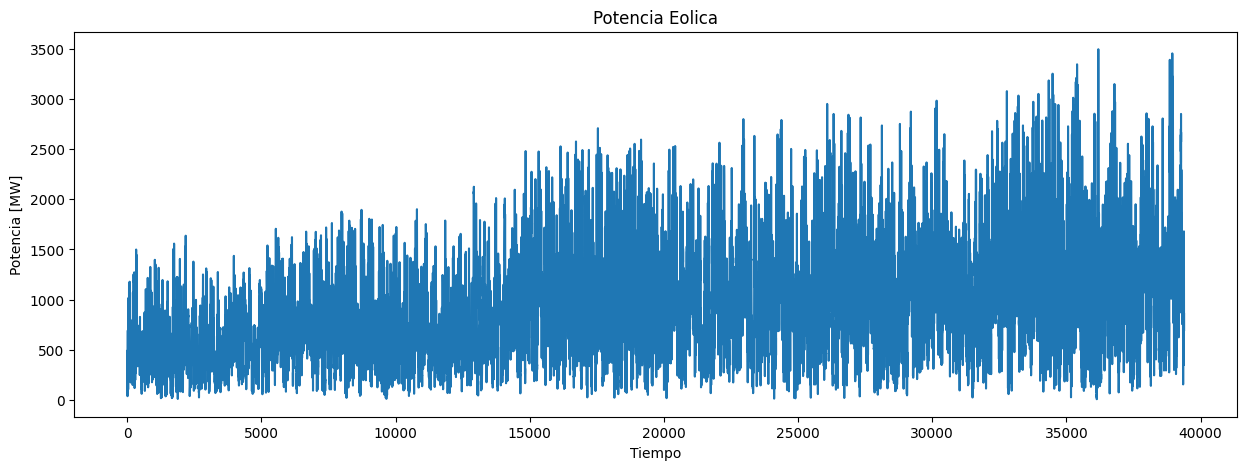

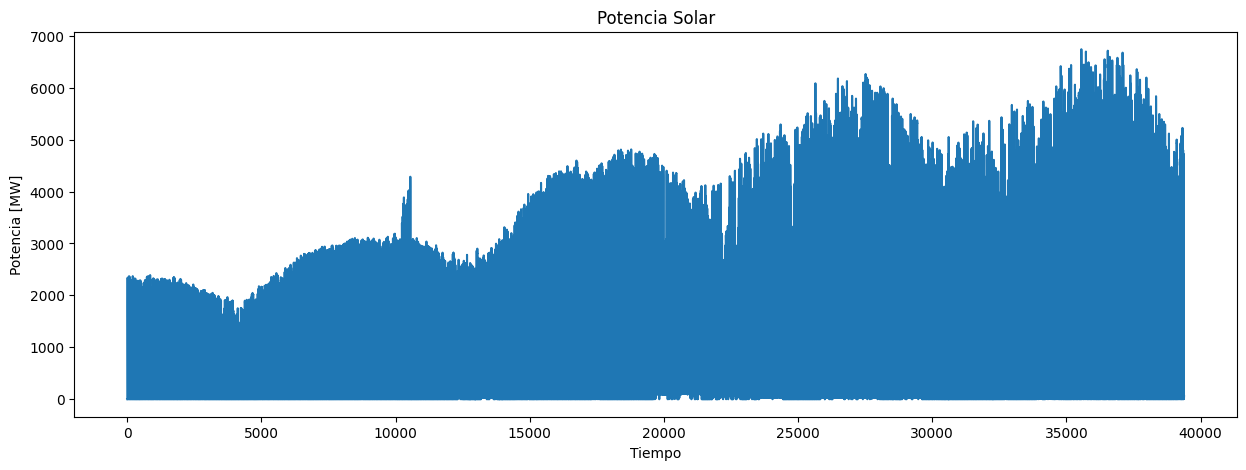

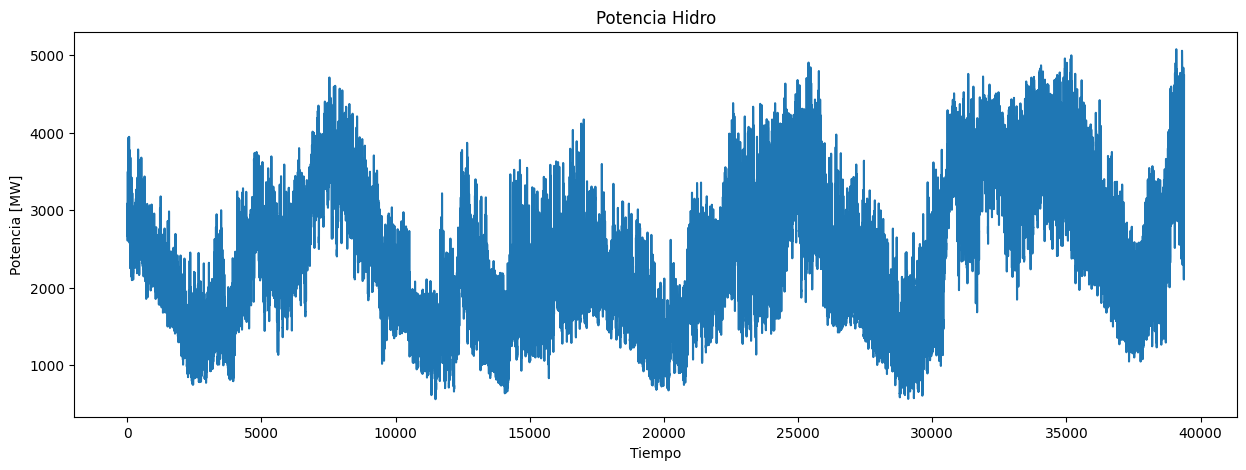

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def PlotData(df_input: pd.DataFrame, title: str, xlabel: str, ylabel: str, save: bool = False, save_path: str = None):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data=df_input, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if save:
        plt.savefig(save_path)
    plt.show()

PlotData(df_PotenciaSistema_raw["Demanda"], 'Demanda', 'Tiempo', 'Potencia [MW]', save=True, save_path=os.path.join(Output_dir,'PotenciaSistema.png'))
PlotData(df_PotenciaSistema_raw["ERNC"], 'Potencia ERNC', 'Tiempo', 'Potencia [MW]', save=True, save_path=os.path.join(Output_dir,'PotenciaSistema.png'))
PlotData(df_PotenciaSistema_raw["Eolica"], 'Potencia Eolica', 'Tiempo', 'Potencia [MW]', save=True, save_path=os.path.join(Output_dir,'PotenciaSistema.png'))
PlotData(df_PotenciaSistema_raw["Solar"], 'Potencia Solar', 'Tiempo', 'Potencia [MW]', save=True, save_path=os.path.join(Output_dir,'PotenciaSistema.png'))
PlotData(df_PotenciaSistema_raw["Hidro"], 'Potencia Hidro', 'Tiempo', 'Potencia [MW]', save=True, save_path=os.path.join(Output_dir,'PotenciaSistema.png'))


# Visualizacion rapida de centrales
---

In [16]:
# Solar
fig = px.scatter_mapbox(df_sol_info, lat="Latitud", lon="Longitud", hover_name="Nombre", hover_data=["Nombre"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(mapbox_style="open-street-map")

In [17]:
# Wind
fig = px.scatter_mapbox(df_eol_info, 
                        lat="Latitud", lon="Longitud", 
                        hover_name="Nombre",
                        hover_data=["ID"],
                        zoom=4,
                        mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [18]:
# Hydro
fig = px.scatter_mapbox(df_hid_info, 
                        lat="Latitud", lon="Longitud", 
                        hover_name="Nombre",
                        hover_data=["ID"],
                        zoom=4,
                        mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()